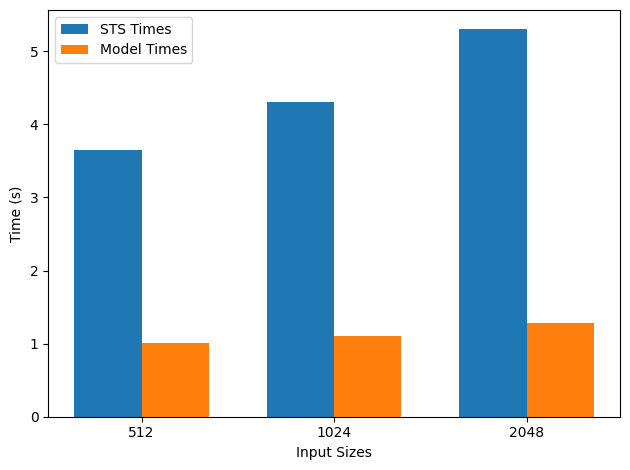

In [16]:
import matplotlib.pyplot as plt

# Input data
input_sizes = [512, 1024, 2048]
sts_times = [3.65, 4.31, 5.30]  # STS times
model_times = [1.01, 1.11, 1.28]  # Model times

# Width of each bar
bar_width = 0.35

# Positions of bars on x-axis
index = range(len(input_sizes))

# Plotting the bars
plt.bar(index, sts_times, bar_width, label='STS Times', color='tab:blue')
plt.bar([i + bar_width for i in index], model_times, bar_width, label='Model Times', color='tab:orange')

# Adding labels
plt.xlabel('Input Sizes')
plt.ylabel('Time (s)')
plt.xticks([i + bar_width/2 for i in index], input_sizes)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Imports

In [2]:
from Model import *
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd

In [60]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
#RNN model with LSTM which takes input and embedds it to a certain dimension and then passes it through the LSTM layer and then the output is passed through a fully connected layer to get the final output
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = 'cpu'
        self.embedding = nn.Embedding(65536, input_size)
        self.pe = PositionalEncoding(input_size)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = 0.2)
        self.fc = nn.Sequential(nn.Linear(hidden_size, num_classes), nn.Sigmoid())
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        x = self.embedding(x)
        # x = self.pe(x)
        out, _ = self.rnn(x, (h0, c0))
        # out = out[:, -1, :]
        out = torch.mean(out, 1)
        out = self.fc(out)
        return out


transformer = RNN(input_size = 200, hidden_size = 200, num_layers = 2, num_classes = 7)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(transformer.parameters())

# train_metrics, val_metrics = train(transformer, criterion, optimizer, train_loader_512, val_loader_512, 2, 0.5, device = 'cpu')

# print("TEST " + input)

# test_metrics = inference(transformer, criterion, test_loader_512, 0.5, device = 'cpu')


# Loading the Datasets

In [3]:
#get the data
split_ratio = 0.8
val_ratio = 0.2
data = pd.read_csv("Data/dataset_512.csv", dtype = str)
train_df = data.sample(frac = split_ratio)
test_df = data.drop(train_df.index)
val_df = train_df.sample(frac = val_ratio)
train_df = train_df.drop(val_df.index)

train_dataset = QueueDataset(train_df)
test_dataset = QueueDataset(test_df)
val_dataset = QueueDataset(val_df)

#initialize the data loader 
train_loader_512 = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader_512 = DataLoader(test_dataset, batch_size = 128, shuffle = True)
val_loader_512 = DataLoader(val_dataset, batch_size = 128, shuffle = True)

data = pd.read_csv("Data/dataset_1024.csv", dtype = str)
train_df = data.sample(frac = split_ratio)
test_df = data.drop(train_df.index)
val_df = train_df.sample(frac = val_ratio)
train_df = train_df.drop(val_df.index)

train_dataset = QueueDataset(train_df)
test_dataset = QueueDataset(test_df)
val_dataset = QueueDataset(val_df)

train_loader_1024 = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader_1024 = DataLoader(test_dataset, batch_size = 128, shuffle = True)
val_loader_1024 = DataLoader(val_dataset, batch_size = 128, shuffle = True)

data = pd.read_csv("Data/dataset_2048.csv", dtype = str)
train_df = data.sample(frac = split_ratio)
test_df = data.drop(train_df.index)
val_df = train_df.sample(frac = val_ratio)
train_df = train_df.drop(val_df.index)

train_dataset = QueueDataset(train_df)
test_dataset = QueueDataset(test_df)
val_dataset = QueueDataset(val_df)

train_loader_2048 = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader_2048 = DataLoader(test_dataset, batch_size = 128, shuffle = True)
val_loader_2048 = DataLoader(val_dataset, batch_size = 128, shuffle = True)

# data = pd.read_csv("Data/dataset_4096.csv", dtype = str)
# train_df = data.sample(frac = split_ratio)
# test_df = data.drop(train_df.index)
# val_df = train_df.sample(frac = val_ratio)
# train_df = train_df.drop(val_df.index)

# train_dataset = QueueDataset(train_df)
# test_dataset = QueueDataset(test_df)
# val_dataset = QueueDataset(val_df)

# train_loader_4096 = DataLoader(train_dataset, batch_size = 128, shuffle = True)
# test_loader_4096 = DataLoader(test_dataset, batch_size = 128, shuffle = True)
# val_loader_4096 = DataLoader(val_dataset, batch_size = 128, shuffle = True)

# Defining the Model

In [5]:
#model hyperparameters 
ntokens = 65536  # size of vocabulary
emsize = 192  # embedding dimension
d_hid = 192  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 1  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 1 # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
threshold = 0.5
input_size = 32
device = "cpu"
torch.cuda.empty_cache() if torch.cuda.is_available() else None
transformer = RandomLM(ntokens, emsize, nhead, d_hid, nlayers, input_size, dropout, True).to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(transformer.parameters())

/home/rishabhg/.conda/envs/Randomness-env/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/rishabhg/.conda/envs/Randomness-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [61]:
for averaging in [True]:
    average = "Averaging" if averaging else "NonAveraging"
    for input in ['512', '1024', '2048']:
        match input:
            case "512":
                train_loader = train_loader_512
                test_loader = test_loader_512
                val_loader = val_loader_512
                input_size = 32
            case "1024":
                train_loader = train_loader_1024
                test_loader = test_loader_1024
                val_loader = val_loader_1024
                input_size = 64
            case "2048":
                train_loader = train_loader_2048
                test_loader = test_loader_2048
                val_loader = val_loader_2048
                input_size = 128
            # case "4096":
            #     train_loader = train_loader_4096
            #     test_loader = test_loader_4096
            #     val_loader = val_loader_4096
            #     input_size = 256
        
        train_metrics, val_metrics = train(transformer, criterion, optimizer, train_loader, val_loader, 3, 0.40, device = 'cpu')
        
        print("TEST " + input)

        test_metrics = inference(transformer, criterion, test_loader, 0.40, device = 'cpu')

epoch: 1, batch: 100, train loss: 0.349, train macro: 0.799, train micro: 0.851, train sample: 0.758, train weighted 0.822, val loss: 0.195, val macro: 0.937, val micro: 0.941 val sample: 0.829 val weighted: 0.941
epoch: 1, batch: 200, train loss: 0.187, train macro: 0.939, train micro: 0.943, train sample: 0.853, train weighted 0.943, val loss: 0.168, val macro: 0.945, val micro: 0.949 val sample: 0.873 val weighted: 0.949
epoch: 1, batch: 300, train loss: 0.161, train macro: 0.948, train micro: 0.952, train sample: 0.877, train weighted 0.953, val loss: 0.158, val macro: 0.949, val micro: 0.953 val sample: 0.878 val weighted: 0.954
epoch: 1, batch: 400, train loss: 0.161, train macro: 0.948, train micro: 0.952, train sample: 0.879, train weighted 0.952, val loss: 0.150, val macro: 0.951, val micro: 0.956 val sample: 0.886 val weighted: 0.956
epoch: 1, batch: 500, train loss: 0.148, train macro: 0.952, train micro: 0.957, train sample: 0.886, train weighted 0.957, val loss: 0.145, val

KeyboardInterrupt: 

# Training Model

In [6]:
test = "EmbeddingsResults/"
test_types = [288]

for test_number in test_types:
    emsize = test_number
    d_hid = test_number
    test_type = "/" + str(test_number) + "emsize/"

    for averaging in [False]:
        average = "Averaging" if averaging else "NonAveraging"
        for input in ["1024"]:
            match input:
                case "512":
                    train_loader = train_loader_512
                    test_loader = test_loader_512
                    val_loader = val_loader_512
                    path = test + average + test_type + input
                    input_size = 32
                case "1024":
                    train_loader = train_loader_1024
                    test_loader = test_loader_1024
                    val_loader = val_loader_1024
                    path = test + average + test_type + input
                    input_size = 64
                case "2048":
                    train_loader = train_loader_2048
                    test_loader = test_loader_2048
                    val_loader = val_loader_2048
                    path = test + average + test_type + input
                    input_size = 128
                # case "4096":
                #     train_loader = train_loader_4096
                #     test_loader = test_loader_4096
                #     val_loader = val_loader_4096
                #     path = test + average + test_type + input
                #     input_size = 256

            print("TRAIN " + input)

            torch.cuda.empty_cache() if torch.cuda.is_available() else None

            transformer = RandomLM(ntokens, emsize, nhead, d_hid, nlayers, input_size, dropout, averaging).to(device)
            criterion = nn.BCELoss().to(device)
            optimizer = torch.optim.Adam(transformer.parameters())

            train_metrics, val_metrics = train(transformer, criterion, optimizer, train_loader, val_loader, 3, threshold, device = device)
            
            print("TEST " + input)

            test_metrics = inference(transformer, criterion, test_loader, threshold, device = device)
            model_save(transformer, path, train_metrics, val_metrics, test_metrics)

    del transformer, criterion, optimizer

TRAIN 1024


/home/rishabhg/.conda/envs/Randomness-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch: 1, batch: 100, train loss: 36.266, train macro: 0.505, train micro: 0.700, train sample: 0.645, train weighted 0.575, val loss: 37.512, val macro: 0.481, val micro: 0.690 val sample: 0.635 val weighted: 0.553
epoch: 1, batch: 200, train loss: 37.701, train macro: 0.482, train micro: 0.689, train sample: 0.635, train weighted 0.552, val loss: 37.505, val macro: 0.481, val micro: 0.690 val sample: 0.635 val weighted: 0.553
epoch: 1, batch: 300, train loss: 37.760, train macro: 0.480, train micro: 0.688, train sample: 0.632, train weighted 0.551, val loss: 37.510, val macro: 0.481, val micro: 0.690 val sample: 0.635 val weighted: 0.553
epoch: 1, batch: 400, train loss: 37.599, train macro: 0.481, train micro: 0.689, train sample: 0.635, train weighted 0.553, val loss: 37.501, val macro: 0.481, val micro: 0.690 val sample: 0.635 val weighted: 0.553
epoch: 1, batch: 500, train loss: 37.281, train macro: 0.481, train micro: 0.691, train sample: 0.637, train weighted 0.555, val loss: 3

# Pre-Trained Models

## Metrics

In [ ]:
path = "TrainedModels/240embeddings-3encoder-24heads-128tokensize"

with ZipFile(path + ".zip", "r") as myzip:
    myzip.extractall("temp/")

train_metrics = pd.read_csv("temp/train_metrics.csv", index_col = 0)
val_metrics = pd.read_csv("temp/val_metrics.csv", index_col = 0)

plot_metrics(train_metrics, val_metrics)

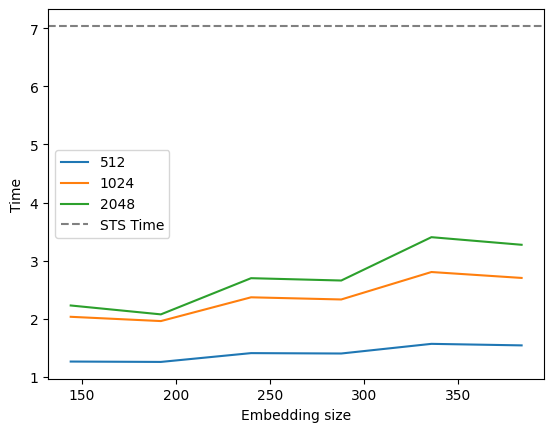

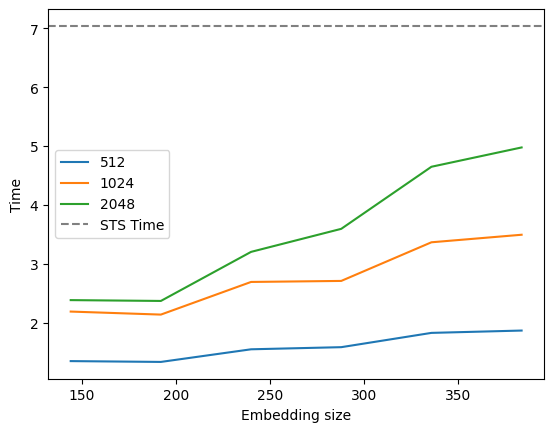

In [2]:
path1 = 'EncoderResults/'
tests1 = ['1encoder/', '2encoder/', '3encoder/', '4encoder/', '5encoder/', '6encoder/', '7encoder/', '8encoder/']

path2 = 'HeadsResults/'
tests2 = ['1head/', '2head/', '4head/', '6head/', '8head/', '12head/', '16head/', '20head/', '24head/']

path3 = 'EmbeddingsResults/'
tests3 = ['144emsize/', '192emsize/', '240emsize/', '288emsize/', '336emsize/', '384emsize/']

visualize_exeperiment(path3, tests3, 'Time')

## Inference

In [ ]:
model = torch.load("temp/model.pt")

# data_loader = None #loader for the data
# inference(model, criterion, test_loader, threshold)

In [2]:
import os 

os.remove("temp/train_metrics.csv")
os.remove("temp/val_metrics.csv")
if (os.path.exists("temp/model.pth")):
    os.remove("temp/model.pth")
if (os.path.exists("temp/model.pt")):
    os.remove("temp/model.pt")
os.rmdir("temp")